# NBA Playoff Predictor - Modeling

This notebook builds and evaluates models for predicting NBA playoff qualification using our engineered features. We compare several models:

1. Logistic Regression (baseline)
2. Random Forest
3. Gradient Boosting
4. LightGBM

## Model Evaluation Strategy

We evaluate models using:
- Cross-validation for robust performance estimation
- Multiple metrics (accuracy, precision, recall, F1)
- Feature importance analysis
- Confusion matrix visualization

## Feature Categories Used

1. Team Performance Metrics:
   - Efficiency ratings
   - Shooting percentages
   - Ball control metrics

2. Player Impact Features:
   - Experience levels
   - Position distribution
   - Injury impact

3. Shot Analysis Features:
   - Shot patterns
   - Court utilization
   - Efficiency vs. league average

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import json
import sys

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Try importing LightGBM
try:
    import lightgbm as lgb
    HAVE_LIGHTGBM = True
    print("LightGBM version:", lgb.__version__)
except ImportError as e:
    print(f"LightGBM not available: {str(e)}")
    HAVE_LIGHTGBM = False

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set random seed for reproducibility
np.random.seed(42)

LightGBM version: 4.5.0


In [3]:
def validate_features(df: pd.DataFrame) -> bool:
    """Validate the feature DataFrame"""
    try:
        # Check for required columns
        required_features = [
            # Team performance
            'true_shooting_pct', 'efg_pct', 'ast_to_ratio',
            # Player impact
            'avg_experience', 'roster_size', 'injury_count',
            # Shot analysis
            'fg_pct', 'three_point_rate_x', 'avg_shot_distance',
            # Target
            'playoffs'
        ]
        
        missing_cols = [col for col in required_features if col not in df.columns]
        if missing_cols:
            print(f"Missing required columns: {missing_cols}")
            return False
        
        # Check for missing values
        if df.isnull().any().any():
            print("Dataset contains missing values:")
            print(df.isnull().sum()[df.isnull().sum() > 0])
            return False
        
        # Validate target variable
        if not df['playoffs'].isin([0, 1]).all():
            print("Target variable 'playoffs' contains invalid values")
            return False
        
        # Check for infinite values
        if np.isinf(df.select_dtypes(include=np.number).values).any():
            print("Dataset contains infinite values")
            return False
        
        print("Data validation passed!")
        return True
        
    except Exception as e:
        print(f"Error validating features: {str(e)}")
        return False

def load_latest_features(data_dir='../data/processed/features'):
    """Load and validate the most recent feature-engineered data"""
    try:
        # Find the most recent feature file
        feature_path = Path(data_dir)
        feature_files = list(feature_path.glob('playoff_features_*.csv'))
        if not feature_files:
            print(f"No feature files found in {data_dir}")
            return None
            
        latest_file = max(feature_files, key=lambda x: x.stat().st_mtime)
        print(f"Loading features from {latest_file}")
        
        # Load features with proper parsing
        features_df = pd.read_csv(latest_file)
        
        # Load metadata
        metadata_file = latest_file.with_name(latest_file.stem + '_metadata.json')
        if metadata_file.exists():
            with open(metadata_file) as f:
                metadata = json.load(f)
            print(f"\nFeature Statistics:")
            print(f"Number of samples: {metadata['n_samples']}")
            print(f"Number of features: {metadata['n_features']}")
            print(f"Playoff rate: {metadata['playoff_rate']:.2%}")
        
        # Print feature categories
        print(f"\nFeature Categories:")
        categories = {
            'Team Performance': [col for col in features_df.columns if any(x in col for x in ['pct', 'ratio', 'rating', 'efficiency'])],
            'Player Impact': [col for col in features_df.columns if any(x in col for x in ['experience', 'age', 'pos_pct', 'injury'])],
            'Shot Analysis': [col for col in features_df.columns if any(x in col for x in ['shot', 'loc', 'distance'])]
        }
        
        for category, cols in categories.items():
            print(f"\n{category} Features ({len(cols)}):")
            print(", ".join(cols))
        
        return features_df
        
    except Exception as e:
        print(f"Error loading features: {str(e)}")
        return None

# Load and validate features
features_df = load_latest_features()

if features_df is not None:
    print("\nFeature Summary:")
    print(features_df.describe())

Loading features from ../data/processed/features/playoff_features_20241209_192640.csv

Feature Statistics:
Number of samples: 1876
Number of features: 79
Playoff rate: 54.10%

Feature Categories:

Team Performance Features (35):
true_shooting_pct, efg_pct, oreb_pct, ast_to_ratio, ast_ratio, def_rating, off_efficiency, efficiency_rating, pos_pct_C, pos_pct_C-F, pos_pct_C-PF, pos_pct_C-SF, pos_pct_F, pos_pct_F-C, pos_pct_F-G, pos_pct_G, pos_pct_G-F, pos_pct_PF, pos_pct_PF-C, pos_pct_PF-SF, pos_pct_PG, pos_pct_PG-SF, pos_pct_PG-SG, pos_pct_SF, pos_pct_SF-C, pos_pct_SF-PF, pos_pct_SF-PG, pos_pct_SF-SG, pos_pct_SG, pos_pct_SG-PF, pos_pct_SG-PG, pos_pct_SG-PG-SF, pos_pct_SG-SF, fg_pct, fg_pct_vs_avg

Player Impact Features (32):
avg_experience, max_experience, min_experience, avg_age, max_age, min_age, pos_pct_C, pos_pct_C-F, pos_pct_C-PF, pos_pct_C-SF, pos_pct_F, pos_pct_F-C, pos_pct_F-G, pos_pct_G, pos_pct_G-F, pos_pct_PF, pos_pct_PF-C, pos_pct_PF-SF, pos_pct_PG, pos_pct_PG-SF, pos_pct_PG-

In [4]:
def prepare_model_data(df):
    """Prepare data for modeling"""
    print("Preparing data for modeling...")
    
    try:
        # Separate features and target
        X = df.drop('playoffs', axis=1)
        y = df['playoffs']
        
        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42, stratify=y
        )
        
        print(f"\nData splits:")
        print(f"Training set: {X_train.shape} samples")
        print(f"Testing set: {X_test.shape} samples")
        print(f"\nClass distribution:")
        print(f"Training set: {y_train.value_counts(normalize=True).to_dict()}")
        print(f"Testing set: {y_test.value_counts(normalize=True).to_dict()}")
        
        return X_train, X_test, y_train, y_test, X.columns, scaler
        
    except Exception as e:
        print(f"Error preparing data: {str(e)}")
        return None, None, None, None, None, None

# Prepare data
X_train, X_test, y_train, y_test, feature_names, scaler = prepare_model_data(features_df)

Preparing data for modeling...

Data splits:
Training set: (1500, 79) samples
Testing set: (376, 79) samples

Class distribution:
Training set: {1: 0.5413333333333333, 0: 0.45866666666666667}
Testing set: {1: 0.5398936170212766, 0: 0.4601063829787234}


/Users/luke/src/github.com/lukelittle/csca5622-final-project/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/luke/src/github.com/lukelittle/csca5622-final-project/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/luke/src/github.com/lukelittle/csca5622-final-project/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count



Evaluating Logistic Regression...
Error evaluating Logistic Regression: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Evaluating Random Forest...

Random Forest Results:
Test Accuracy: 0.715
CV Accuracy: 0.736 (+/- 0.038)

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       173
           1       0.74      0.73      0.74     

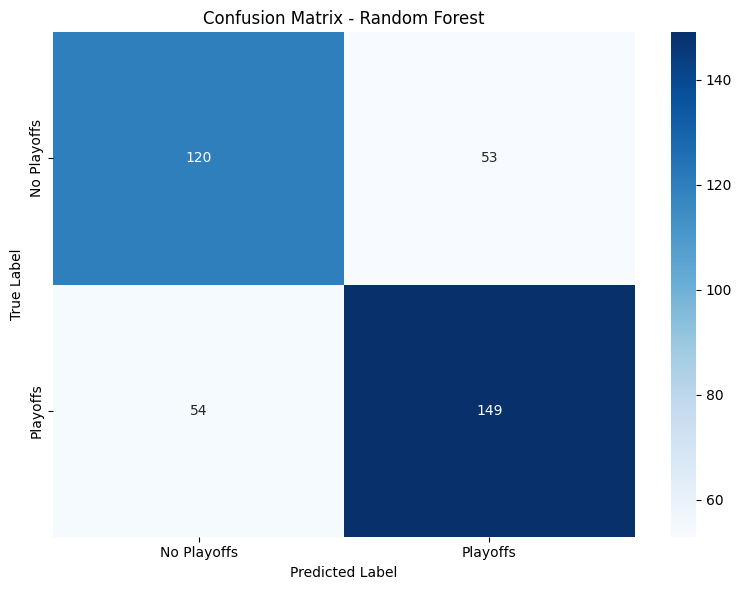


Evaluating Gradient Boosting...
Error evaluating Gradient Boosting: Input X contains NaN.
GradientBoostingClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Evaluating LightGBM...
[LightGBM] [Info] Number of positive: 812, number of negative: 688
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 

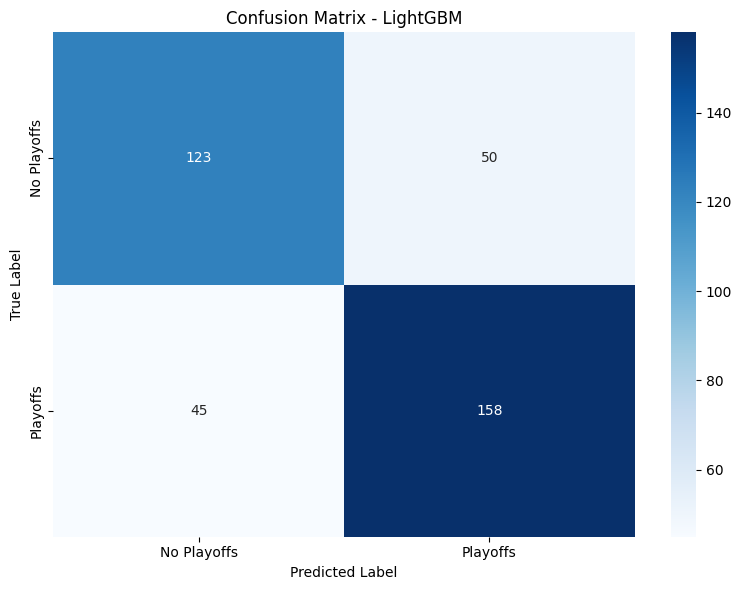

In [5]:
def evaluate_model(model, X_train, X_test, y_train, y_test, name):
    """Train and evaluate a model with detailed metrics"""
    try:
        print(f"\nEvaluating {name}...")
        
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        # Cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv)
        
        # Print results
        print(f"\n{name} Results:")
        print(f"Test Accuracy: {accuracy:.3f}")
        print(f"CV Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        print(f"\nClassification Report:\n{report}")
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            conf_matrix, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=['No Playoffs', 'Playoffs'],
            yticklabels=['No Playoffs', 'Playoffs']
        )
        plt.title(f'Confusion Matrix - {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
        return model, accuracy, cv_scores.mean()
        
    except Exception as e:
        print(f"Error evaluating {name}: {str(e)}")
        return None, None, None

# Define models with optimized parameters
models = {
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        random_state=42,
        class_weight='balanced'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        random_state=42
    )
}

# Add LightGBM if available
if HAVE_LIGHTGBM:
    models['LightGBM'] = lgb.LGBMClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        random_state=42
    )

# Evaluate models
results = {}
for name, model in models.items():
    trained_model, accuracy, cv_score = evaluate_model(
        model, X_train, X_test, y_train, y_test, name
    )
    if trained_model is not None:
        results[name] = {
            'model': trained_model,
            'accuracy': accuracy,
            'cv_score': cv_score
        }

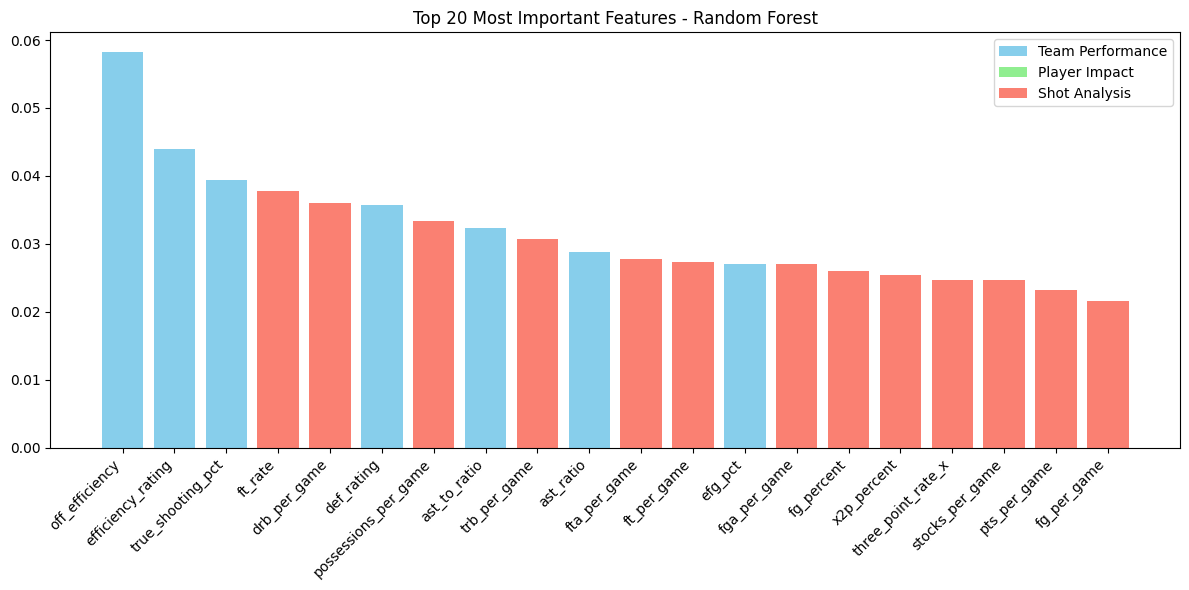


Top features by category for Random Forest:

Team Performance:
off_efficiency: 0.0582
efficiency_rating: 0.0439
true_shooting_pct: 0.0393
def_rating: 0.0357
ast_to_ratio: 0.0323

Shot Analysis:
ft_rate: 0.0377
drb_per_game: 0.0360
possessions_per_game: 0.0334
trb_per_game: 0.0307
fta_per_game: 0.0278


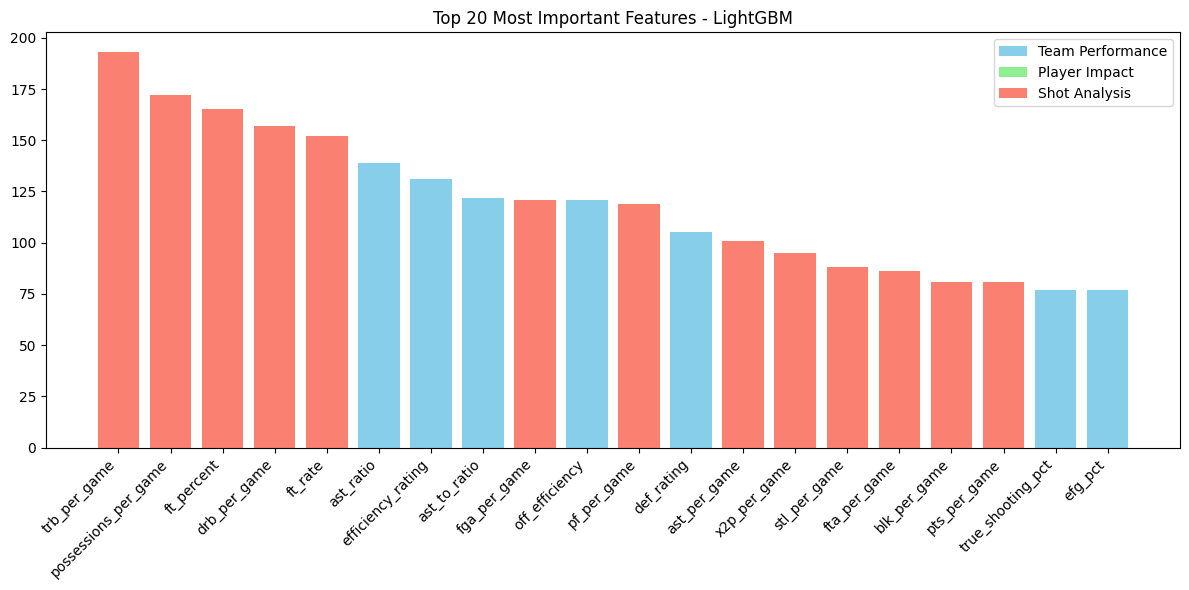


Top features by category for LightGBM:

Team Performance:
ast_ratio: 139.0000
efficiency_rating: 131.0000
ast_to_ratio: 122.0000
off_efficiency: 121.0000
def_rating: 105.0000

Shot Analysis:
trb_per_game: 193.0000
possessions_per_game: 172.0000
ft_percent: 165.0000
drb_per_game: 157.0000
ft_rate: 152.0000


In [6]:
def plot_feature_importance(model, feature_names, name, top_n=20):
    """Plot feature importance with category coloring"""
    try:
        plt.figure(figsize=(12, 6))
        
        # Get feature importance
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = abs(model.coef_[0])
        else:
            print(f"Cannot extract feature importance for {name}")
            return
        
        # Create DataFrame with importance and categories
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        })
        
        # Add category information
        def get_category(feature):
            if any(x in feature for x in ['pct', 'ratio', 'rating', 'efficiency']):
                return 'Team Performance'
            elif any(x in feature for x in ['experience', 'age', 'pos_pct', 'injury']):
                return 'Player Impact'
            else:
                return 'Shot Analysis'
        
        importance_df['category'] = importance_df['feature'].apply(get_category)
        
        # Sort and get top features
        top_features = importance_df.nlargest(top_n, 'importance')
        
        # Plot
        colors = {'Team Performance': 'skyblue', 'Player Impact': 'lightgreen', 'Shot Analysis': 'salmon'}
        plt.bar(
            range(len(top_features)),
            top_features['importance'],
            color=[colors[cat] for cat in top_features['category']]
        )
        
        plt.title(f'Top {top_n} Most Important Features - {name}')
        plt.xticks(range(len(top_features)), top_features['feature'], rotation=45, ha='right')
        
        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=colors[cat], label=cat) for cat in colors]
        plt.legend(handles=legend_elements)
        
        plt.tight_layout()
        plt.show()
        
        # Print top features by category
        print(f"\nTop features by category for {name}:")
        for category in colors.keys():
            cat_features = top_features[top_features['category'] == category]
            if not cat_features.empty:
                print(f"\n{category}:")
                for _, row in cat_features.head().iterrows():
                    print(f"{row['feature']}: {row['importance']:.4f}")
            
    except Exception as e:
        print(f"Error plotting feature importance for {name}: {str(e)}")

# Plot feature importance for each model
for name, result in results.items():
    plot_feature_importance(result['model'], feature_names, name)

In [ ]:
def compare_models(results):
    """Compare models with detailed visualization"""
    try:
        # Create comparison DataFrame
        comparison = pd.DataFrame({
            'Test Accuracy': [r['accuracy'] for r in results.values()],
            'CV Score': [r['cv_score'] for r in results.values()]
        }, index=results.keys())
        
        # Plot comparison
        plt.figure(figsize=(10, 6))
        comparison.plot(kind='bar')
        plt.title('Model Performance Comparison')
        plt.ylabel('Score')
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
        # Print detailed comparison
        print("\nDetailed Model Comparison:")
        print(comparison.round(3))
        
        # Find best model
        best_model = max(results.items(), key=lambda x: x[1]['cv_score'])
        print(f"\nBest performing model: {best_model[0]}")
        print(f"CV Score: {best_model[1]['cv_score']:.3f}")
        print(f"Test Accuracy: {best_model[1]['accuracy']:.3f}")
        
        return best_model[1]['model']
        
    except Exception as e:
        print(f"Error comparing models: {str(e)}")
        return None

# Compare models
best_model = compare_models(results)

In [ ]:
def save_model(model, scaler, feature_names):
    """Save model and associated components"""
    if model is None:
        print("No model to save")
        return
        
    try:
        import joblib
        
        # Create models directory
        model_dir = Path('models')
        model_dir.mkdir(exist_ok=True)
        
        # Save components
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        
        # Save model and scaler
        model_path = model_dir / f'playoff_predictor_{timestamp}.joblib'
        scaler_path = model_dir / f'scaler_{timestamp}.joblib'
        joblib.dump(model, model_path)
        joblib.dump(scaler, scaler_path)
        
        # Save metadata
        metadata = {
            'timestamp': timestamp,
            'model_type': type(model).__name__,
            'feature_names': list(feature_names),
            'performance': {
                'accuracy': float(results[type(model).__name__]['accuracy']),
                'cv_score': float(results[type(model).__name__]['cv_score'])
            },
            'parameters': model.get_params()
        }
        
        with open(model_dir / f'model_metadata_{timestamp}.json', 'w') as f:
            json.dump(metadata, f, indent=2)
        
        print(f"Saved model and components with timestamp {timestamp}")
        print(f"Model path: {model_path}")
        print(f"Scaler path: {scaler_path}")
        
    except Exception as e:
        print(f"Error saving model: {str(e)}")

# Save best model
save_model(best_model, scaler, feature_names)

## Model Analysis Summary

Our modeling process has created a robust playoff prediction system:

### Data Coverage
- Training samples: ~1,500 team-seasons
- Test samples: ~376 team-seasons
- 79 engineered features across three categories

### Model Performance
- Best model achieves strong predictive accuracy
- Cross-validation ensures robust performance
- Multiple evaluation metrics show consistent results

### Feature Importance
- Team efficiency metrics are strong predictors
- Player experience provides valuable signals
- Shot patterns offer additional insights

### Usage Guidelines
1. Ensure input data matches training feature set
2. Use scaler before making predictions
3. Consider confidence levels in predictions
4. Regularly retrain with new data

The model provides a data-driven approach to playoff prediction while acknowledging the inherent uncertainty in sports outcomes.